# seq2seq with attention
目的：フランス語から英語への翻訳

https://torch.classcat.com/2021/04/23/pytorch-1-8-tutorials-intermediate-seq2seq-translation/

上記サイトは下記チュートリアルの翻訳：  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 単語の one-hot encoding へ向けた準備
SOS_token = 0
EOS_token = 1

# フランス語／英語それぞれにコードブックが必要なため Lang クラスを準備する
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# (注) 以下は単語数を減らすための工夫であり，本質的でない。

# Unicode 文字を ASCII に変え、総てを小文字にして、そして殆どの句読点をトリム
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
# データ読み込みの準備
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
# (注) 単語数チェックは必要だが，トリミングは本質的でない。

# データセットを比較的短くて単純なセンテンスだけにトリム
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    # データ読み込み
    # input_lang / output_lang には「単語とIDのコードブック」が格納される
    # pairs には「フランス語文と英語文のペア」が格納される
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    # 単語数が MAX_LENGTH を超える文の除去 & eng_prefixes で定義された文型のみに絞り込む
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    # 全データについて，単語と ID を紐付ける
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    # (参考) 単語数のカウント
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['ils sont medecins .', 'they re doctors .']


---
## seq2seq モデル

エンコーダが生成する(単一の)ベクトル = 理想的には、入力センテンスの「意味」

In [7]:
# エンコーダ
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        # output = embedded # (メモ) 余分な記述ゆえ，書き直し
        # output, hidden = self.gru(output, hidden) # (メモ) 余分な記述ゆえ，書き直し
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    # エンコーダへ渡す初期隠れ状態 (zero ベクトル)
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
# デコーダ
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    # デコーダへ渡す初期隠れ状態 (zero ベクトル) ・・・(メモ) seq2seq モデルでは不要では？
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [29]:
# attention デコーダ
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # print("input:", input.size()) # torch.Size([1, 1]
        # print("embedded:", embedded.size()) # torch.Size([1, 1, 256]
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        print("attn_weights:", attn_weights.size()) # torch.Size([1, 10]) ・・・入力文の単語数に依存
        print("encoder_outputs:", encoder_outputs.size()) # torch.Size([10, 256])
        print("encoder_outputs.unsqueeze(0):", encoder_outputs.unsqueeze(0).size()) # torch.Size([1, 10, 256])
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 学習

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # エンコーダの初期隠れ層を定義 (zero ベクトル)
    encoder_hidden = encoder.initHidden()

    # optimizer の初期化
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # 入力，出力それぞれに含まれる単語数
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # エンコードの全ての隠れ層の値を保存するための変数
    # 長さが MAX_LENGTH である点に注意
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # エンコード : 埋め込み + GRU
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # 隠れ層の値を溜める
        encoder_outputs[ei] = encoder_output[0, 0]

    # デコーダに与える最初のトークン : SOS_token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # デコーダに与える隠れ層の初期値は，エンコーダの最終隠れ層の値
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # デコード
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # デコードの結果と所望の出力（この例では，期待する英単語）から損失を求める
            loss += criterion(decoder_output, target_tensor[di])
            # デコーダに与える次のトークンを準備
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # 文ペアを１つ，エンコード／デコードし終えたならば逆伝搬
    loss.backward()

    # エンコーダー／デコーダそれぞれの optimizer を更新
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
# helper functions
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [27]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # optimizer の定義
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # 学習対象とするフランス語文／英語文のペアをランダムな順序，かつ重複ありにて生成
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    # 損失関数の定義
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # 学習対象とするフランス語文／英語文のペアをひとつ選ぶ
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # 学習
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # ログ出力
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # 損失の可視化
    showPlot(plot_losses)

In [14]:
# 損失の可視化
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [30]:
# 学習
hidden_size = 256 # GRU の隠れ層のサイズ

# エンコーダ／デコーダの定義
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# 学習 (重複ありにて 75000ペアを学習させる)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weigh

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weigh

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): t

encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs: torch.Size([10, 256])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_weights: torch.Size([1, 10])
encoder_outputs

KeyboardInterrupt: 

## 評価

In [18]:
# 評価
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # (メモ) 元が zero vector だからよいけど，代入じゃ駄目なの？

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> il est plutot optimiste .
= he is rather optimistic .
< he is rather optimistic . 

> j en ai marre de penser .
= i m done thinking .
< i m sick of listening . 

> vous etes tres sceptique .
= you re very skeptical .
< you re very skeptical . 

> elle n est pas assez bonne pour lui .
= she isn t good enough for him .
< she isn t good enough for him . 

> il est connu comme un grand peintre .
= he is known as a great painter .
< he is known as a great painter . 

> je suis assez content .
= i m happy enough .
< i m fairly happy . 

> je vais nager quotidiennement .
= i m going to swim every day .
< i m going to swim to swim . 

> je suis en chemin .
= i m on my way .
< i m on my way . 

> il est aussi grand qu elle .
= he is as tall as her .
< he is as tall as she is . 

> elle est aussi jolie que sa s ur .
= she s as pretty as her sister .
< she s as pretty as her sister . 



## attention の可視化

['i', 'm', 'too', 'slow', '.', '']


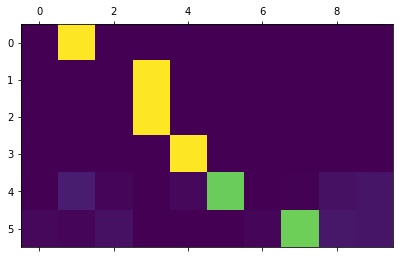

In [25]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
print(output_words)
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me am 


/tmp/ipykernel_635462/2756631201.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_635462/2756631201.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


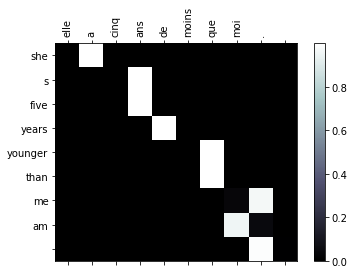

input = elle est trop petit .
output = she is too short . 


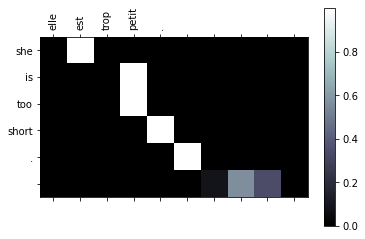

input = je ne crains pas de mourir .
output = i m not scared of die . 


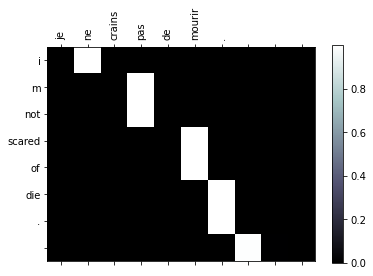

input = c est un jeune directeur plein de talent .
output = he s a talented young director . 


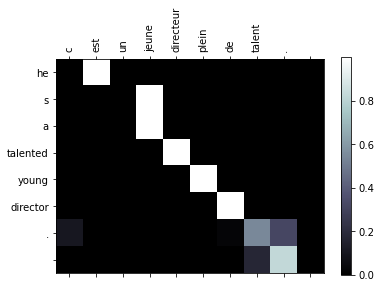

In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [''], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")